In [2]:
import numpy as np
import polars as pl
from sklearn.preprocessing import LabelEncoder


data = pl.read_csv("../data/raw_data/train.csv")


def add_state_avg_salary(data):
    """Add state average salary column based on job_state"""
    abbr_to_mean = {
        "NH": 97046, "MA": 94651, "OR": 94286, "PA": 93864, "NY": 93391,
        "MD": 92244, "WV": 90701, "TX": 89407, "VT": 89074, "NV": 88635,
        "CA": 87957, "ND": 87795, "VA": 86648, "ME": 86128, "WI": 85718,
        "DE": 85112, "NM": 84814, "KS": 84508, "OK": 84153, "WA": 83605,
        "AZ": 83199, "TN": 82354, "ID": 82316, "MS": 80873, "AR": 79907,
        "KY": 78545, "SC": 78256, "WY": 77540, "UT": 77455, "AL": 76867,
        "RI": 76628, "GA": 76574, "IL": 76205, "MN": 75504, "MT": 75309,
        "NJ": 74480, "IN": 73188, "IA": 72526, "CT": 72447, "NC": 71590,
        "CO": 71342, "MO": 70645, "FL": 70393, "OH": 68590, "HI": 67412,
        "LA": 67027, "AK": 65498, "NE": 65123, "SD": 62823, "MI": 61400
    }
    global_mean = sum(abbr_to_mean.values()) / len(abbr_to_mean)
    
    data = data.with_columns(
        pl.col("job_state")
        .cast(pl.Utf8)
        .replace(abbr_to_mean, default=global_mean)
        .fill_null(global_mean)
        .alias("state_avg_salary")
    ).drop("job_state")
    
    return data

def fill_missing_data(X):
    """Fill missing data using KNN imputation"""
    # Split columns into job_desc vs. everything else
    job_desc_cols = [c for c in X.columns if c.startswith("job_desc_")]
    other_cols = [c for c in X.columns if c not in job_desc_cols]

    # Fill non-job_desc columns with their means first
    other_filled = X.select(other_cols).with_columns([
        pl.col(c).fill_null(pl.col(c).mean()).alias(c)
        for c in other_cols
    ])

    # Convert to pandas for KNNImputer
    X_pd = X.to_pandas()

    # Fill non-job_desc columns with their means
    for col in other_cols:
        if X_pd[col].isna().any():
            X_pd[col] = X_pd[col].fillna(X_pd[col].mean())

    # Mask zeros in job_desc columns as nulls
    for col in job_desc_cols:
        X_pd.loc[X_pd[col] == 0, col] = np.nan

    # Apply KNN imputation
    imputer = KNNImputer(
        missing_values=np.nan,
        n_neighbors=5,
        weights="distance"
    )
    X_imputed = imputer.fit_transform(X_pd)

    # Create result DataFrame
    result = pl.DataFrame(X_imputed, schema=X.columns)

    return result


In [2]:
data = data.with_columns(
    pl.col("job_posted_date").str.strptime(pl.Date, format="%Y/%m"),
    pl.col("job_title").cast(pl.Categorical),
    pl.col("job_state").cast(pl.Categorical),
    pl.col("feature_1").cast(pl.Categorical),
    pl.col(pl.Boolean).cast(pl.Int32)
)


data = data.with_columns(
    pl.col("salary_category").cast(pl.Categorical),
)

# Define column groups
feature_cols = [f"feature_{i}" for i in range(1, 13)]
job_desc_cols = [f"job_desc_{i:03d}" for i in range(1, 301)]
extra_feature = ["state_avg_salary", "job_title", "months_since_ref", "month", "jd_norm"]

# Calculate reference date
ref = data["job_posted_date"].min()
ref_total = ref.year * 12 + ref.month - 1

# Add time-based features
data = data.with_columns([
    # Linear trend: months since ref
    (
        (pl.col("job_posted_date").dt.year() * 12 +
         pl.col("job_posted_date").dt.month() - 1)
        - ref_total
    ).alias("months_since_ref"),
    pl.col("job_posted_date").dt.month().alias("month"),
])

# Add job description norm feature
data = data.with_columns(
    np.sqrt(sum(pl.col(c) ** 2 for c in job_desc_cols)).alias("jd_norm")
)

# Add state average salary
data = add_state_avg_salary(data)

# Prepare features
total_features = feature_cols + job_desc_cols + extra_feature
X = data.select(total_features).to_dummies(
    columns=["job_title", "feature_1"]
)


Y = data["salary_category"]
le = LabelEncoder().fit(Y)
Y_encoded = le.transform(Y)



X = fill_missing_data(X)

C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_27576\481388174.py:29: DeprecationWarning: The `default` parameter for `replace` is deprecated. Use `replace_strict` instead to set a default while replacing values.
  .replace(abbr_to_mean, default=global_mean)


In [3]:
data

obs,job_title,job_posted_date,salary_category,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,job_desc_001,job_desc_002,job_desc_003,job_desc_004,job_desc_005,job_desc_006,job_desc_007,job_desc_008,job_desc_009,job_desc_010,job_desc_011,job_desc_012,job_desc_013,job_desc_014,job_desc_015,job_desc_016,job_desc_017,job_desc_018,job_desc_019,job_desc_020,job_desc_021,…,job_desc_268,job_desc_269,job_desc_270,job_desc_271,job_desc_272,job_desc_273,job_desc_274,job_desc_275,job_desc_276,job_desc_277,job_desc_278,job_desc_279,job_desc_280,job_desc_281,job_desc_282,job_desc_283,job_desc_284,job_desc_285,job_desc_286,job_desc_287,job_desc_288,job_desc_289,job_desc_290,job_desc_291,job_desc_292,job_desc_293,job_desc_294,job_desc_295,job_desc_296,job_desc_297,job_desc_298,job_desc_299,job_desc_300,months_since_ref,month,jd_norm,state_avg_salary
i64,cat,date,cat,cat,f64,i32,i32,i32,i32,i32,i32,i32,f64,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i8,f64,f64
1,"""Others""",2024-07-01,"""High""","""A""",0.6429,0,0,1,1,1,0,0,60.0,1,0,0.193511,2.275482,-0.440363,-0.327473,0.058464,-0.154043,-0.393158,-0.367905,-0.703665,0.562969,0.058359,-0.632267,0.326872,-0.276131,0.098252,0.019475,0.105348,-0.411405,0.635027,-0.192049,3.849681,…,-0.167435,-0.342473,0.185418,-0.233041,-0.016037,0.602155,-0.511326,0.60238,-0.25441,-0.114025,0.08606,-0.012974,0.523685,-0.864781,0.084526,0.15464,0.283154,-0.848735,-0.108635,0.049179,0.210502,-0.53584,0.113221,-0.362079,-0.499308,-0.367894,-0.214881,0.01487,-0.271177,-0.113347,-0.587955,-0.919095,-0.20734,68,7,9.237861,93391.0
2,"""Job_Title_1""",2024-07-01,"""Low""","""A""",0.4678,0,0,0,1,1,1,0,60.0,1,1,0.100152,2.291134,-0.356041,-0.494735,0.038632,-0.356995,-0.63302,-0.444805,-0.252597,0.18721,0.261958,-0.734535,0.264041,-0.209023,0.144627,-0.182167,0.144194,-0.43669,0.405126,-0.240945,3.781854,…,-0.065834,-0.395344,0.04834,-0.198469,0.0261,0.390649,-0.484126,0.53313,-0.196634,-0.330162,0.200502,0.047225,0.263908,-0.817924,-0.069964,0.357457,0.323456,-0.977607,-0.034979,-0.053379,-0.02734,-0.511633,-0.105435,-0.300989,-0.415411,-0.341824,-0.319064,0.042322,-0.124755,0.023489,-0.893224,-0.823024,0.112364,68,7,9.02549,87957.0
3,"""Others""",2024-07-01,"""Low""","""A""",0.461,0,0,0,1,1,1,0,36.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,7,0.0,87957.0
4,"""Others""",2024-07-01,"""Low""","""A""",0.5064,0,0,0,1,1,1,0,72.0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68,7,0.0,87957.0
5,"""Others""",2024-07-01,"""Low""","""A""",0.464,0,0,0,1,1,0,0,48.0,1,1,0.406864,1.986625,-0.726046,-0.316294,0.062115,-0.451118,-0.659871,-0.451544,-0.505597,0.119204,-0.542267,-0.623306,0.048583,-0.103152,-0.007468,0.236105,0.20434,-0.280865,0.203199,-0.435184,3.603102,…,0.175365,-0.272249,-0.008637,-0.153464,-0.001045,0.295818,-0.174998,0.781811,-0.155236,-0.612957,0.254792,-0.063058,0.259242,-0.669112,0.142055,0.200105,0.227985,-0.829408,-0.361299,0.005694,-0.118158,-0.654845,-0.099771,-0.406159,-0.654657,-0.074398,-0.464479,0.081037,-0.136992,-0.27627,-0.696853,-0.601466,0.089939,68,7,9.06218,87957.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1276,"""Job_Title_21""",2024-06-01,"""High""","""A""",0.5391,0,0,0,1,0,0,0,null,1,0,0.247692,2.241664,-0.773778,-0.349046,-0.112922,-0.44366,-0.623765,-0.57448,-0.646541,0.056761,

In [4]:
le_jt = LabelEncoder().fit(data["job_title"])
a = le_jt.transform(data["job_title"])
a

array([27,  0, 27, ...,  1, 11,  0], shape=(1280,))

In [5]:
data["feature_7"].value_counts()

feature_7,count
i32,u32
0,740
1,540


In [6]:
data["feature_1"].value_counts()

feature_1,count
cat,u32
"""A""",1232
"""C""",6
"""D""",5
"""B""",36
"""E""",1


In [7]:
data["months_since_ref"].value_counts()

months_since_ref,count
i32,u32
58,24
54,7
37,2
47,4
64,29
…,…
63,24
41,5
43,1


In [8]:
data["feature_10"].value_counts()

feature_10,count
f64,u32
6.0,3
144.0,6
null,446
24.0,76
48.0,100
…,…
300.0,1
192.0,2
84.0,47


In [9]:
data["month"].value_counts()

month,count
i8,u32
9,25
12,32
7,611
5,70
4,49
…,…
2,46
6,156
8,166


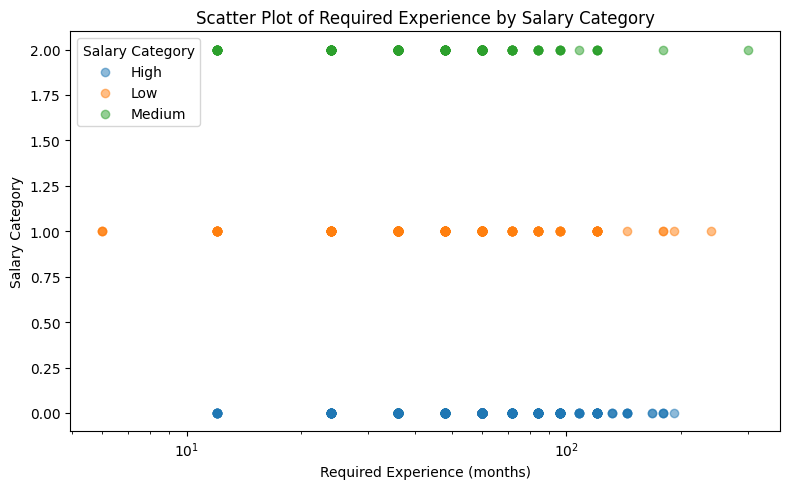

In [10]:
from matplotlib import pyplot as plt
import polars as pl

# Assume the experience column is named 'feature_10'; adjust if different
# Load your dataset as a Polars DataFrame
df_pd = data

# Fill nulls with 0
df_pd = df_pd.fill_null(0)

# Convert experience to integer months using with_columns
df_pd = df_pd.with_columns([
    pl.col("feature_10").cast(pl.Int32).alias("feature_10")
])

# Prepare data for scatter plot
categories = df_pd["salary_category"].unique().to_list()  # Get unique categories

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))

# Loop through each category and plot the data
for i, category in enumerate(categories):
    category_data = df_pd.filter(pl.col("salary_category") == category)
    ax.scatter(category_data["feature_10"].to_list(), [i] * len(category_data), label=category, alpha=0.5)

# Set plot labels and title
ax.set_xlabel("Required Experience (months)")
ax.set_ylabel("Salary Category")
ax.set_title("Scatter Plot of Required Experience by Salary Category")

# Set logarithmic scale on the x-axis
ax.set_xscale('log')

# Add a legend
ax.legend(title="Salary Category")

# Display the plot
plt.tight_layout()
plt.show()


In [11]:
# Assume the experience column is named 'feature_10'; adjust if different
df_pd = data

# Fill nulls with 0
df_pd = df_pd.fill_null(0)

# Convert experience to integer months using with_columns
df_pd = df_pd.with_columns([
    pl.col("feature_10").cast(pl.Int32).alias("feature_10")
])

# Group by 'salary_category' and 'feature_10' and count the occurrences
count_df = df_pd.group_by(["salary_category", "feature_10"]).agg(
    pl.count().alias("count")
).sort("feature_10")

# Convert the result to a Pandas DataFrame for better visualization (optional)
count_df_pd = count_df.to_pandas()

# Print the result
print(count_df_pd)


   salary_category  feature_10  count
0           Medium           0    147
1             High           0    122
2              Low           0    177
3              Low           6      3
4             High          12      9
5           Medium          12     16
6              Low          12     13
7              Low          24     26
8             High          24     22
9           Medium          24     28
10            High          36     64
11          Medium          36     58
12             Low          36     60
13             Low          48     34
14            High          48     42
15          Medium          48     24
16          Medium          60     56
17            High          60    117
18             Low          60     56
19          Medium          72     11
20            High          72     32
21             Low          72     11
22             Low          84     12
23          Medium          84      7
24            High          84     28
25          

C:\Users\StefanConstantin\AppData\Local\Temp\ipykernel_27576\2843333211.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("count")



All coefficients by class:
                           High       Low    Medium
feature                                            
feature_1_A            0.134459 -0.272359  0.137901
feature_1_B           -0.166134  0.280750 -0.114616
feature_1_D            0.056755  0.027558 -0.084313
feature_2              0.463614 -0.678767  0.215153
feature_3              0.201640 -0.200973 -0.000668
...                         ...       ...       ...
job_title_Job_Title_6  0.011877 -0.106760  0.094883
job_title_Job_Title_7  0.074053 -0.091700  0.017647
job_title_Job_Title_8 -0.013542  0.030944 -0.017402
job_title_Job_Title_9  0.139702 -0.036806 -0.102896
job_title_Others      -0.034799  0.126691 -0.091892

[75 rows x 3 columns]

Top 10 parameters by |coefficient|:
         feature   class  coefficient
78     feature_2     Low    -0.678767
3      feature_2    High     0.463614
9      feature_8    High    -0.428693
84     feature_8     Low     0.362215
81     feature_5     Low    -0.289392
76   fea

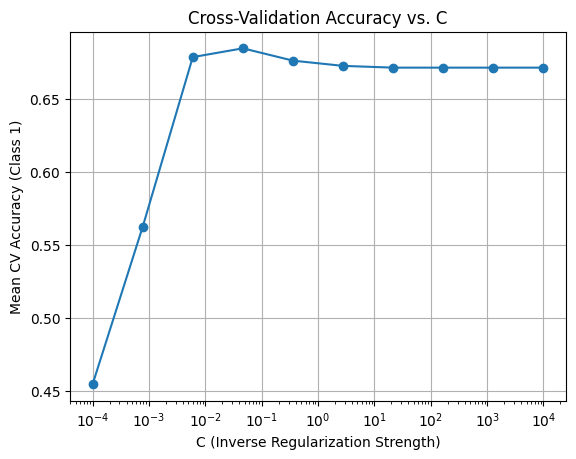

0.6847102696500287


In [4]:
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt

# 1. Load & preprocess
df = pl.read_csv("../data/raw_data/train.csv")
df = df.with_columns(
    pl.col("job_posted_date").str.strptime(pl.Date, format="%Y/%m"),
    pl.col("job_title").cast(pl.Categorical),
    pl.col("salary_category").cast(pl.Categorical),
    pl.col("job_state").cast(pl.Categorical),
    pl.col("feature_1").cast(pl.Categorical),
    pl.col(pl.Boolean).cast(pl.Int32)
).drop_nulls(subset=["feature_10"])

feature_cols   = [f"feature_{i}" for i in range(1, 13)]
extra_feature  = ["job_state", "job_title"]
total_features = feature_cols + extra_feature

X = df.select(total_features)
X = X.to_dummies(columns=["job_state", "job_title", "feature_1"])

# standardize feature_10 in Polars
X = X.with_columns(
    ((pl.col("feature_10") - pl.col("feature_10").mean()) /
     pl.col("feature_10").std()).alias("feature_10")
)

# 2. Polynomial expansion (no bias column)
poly = PolynomialFeatures(degree=1, include_bias=False)
X_np = poly.fit_transform(X.to_numpy())
poly_feature_names = poly.get_feature_names_out(X.columns)

# 3. Normalize all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np)

# 4. Encode target
Y = df["salary_category"].to_pandas()
le = LabelEncoder().fit(Y)
Y_enc = le.transform(Y)

# 5. Cross-validate & fit
clf = LogisticRegressionCV(
    solver='lbfgs',
    max_iter=1000,
    random_state=0,
    penalty='l2',
    cv=10,
    n_jobs=-1,
)

clf.fit(X_scaled, Y_enc)

# 6. Build a DataFrame of coefficients for each class
#    coef_.shape = (n_classes, n_features)
coef_matrix = clf.coef_                     # shape (n_classes, n_features)
class_labels = le.classes_                  # e.g. ['Low', 'Medium', 'High']

# Create DataFrame: rows = features, columns = classes
df_coefs = pd.DataFrame(
    coef_matrix.T,
    index=poly_feature_names,
    columns=class_labels
)
df_coefs.index.name = "feature"

print("\nAll coefficients by class:")
print(df_coefs)

# 7. Find top 10 parameters by absolute magnitude across all classes
df_long = (
    df_coefs
    .reset_index()
    .melt(id_vars="feature", var_name="class", value_name="coefficient")
)
df_long["abs_coef"] = df_long["coefficient"].abs()
top10 = df_long.sort_values("abs_coef", ascending=False).head(10)

print("\nTop 10 parameters by |coefficient|:")
print(top10[["feature", "class", "coefficient"]])

mean_scores = clf.scores_[1].mean(axis=0)
C_values = clf.Cs_

plt.plot(C_values, mean_scores, marker='o')
plt.xscale('log')
plt.xlabel('C (Inverse Regularization Strength)')
plt.ylabel('Mean CV Accuracy (Class 1)')
plt.title('Cross-Validation Accuracy vs. C')
plt.grid(True)
plt.show()

print(mean_scores.max())

In [29]:
Y

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 2, 1, 0, 0, 2, 0, 0, 1, 2,
       0, 2, 1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 2, 0, 0, 0,
       0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0,
       0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 1, 1, 2,
       1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 1, 2, 0, 2, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 1,
       1, 2, 0, 1, 2, 0, 0, 1, 1, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 1, 0, 1,
       0, 0, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0, 2, 1, 0, 0, 1, 1, 1, 1, 2, 0,
       2, 2, 2, 1, 1, 1, 1, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 1, 0, 0, 2, 1,
       1, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 1, 0, 2, 2, 1, 0, 1,
       0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1,

In [34]:


import numpy as np
import pandas as pd
import polars as pl
import torch
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from skopt import BayesSearchCV
from skorch import NeuralNetClassifier
from skopt.space import Real, Integer, Categorical

from Classes.NNModel import NNModel

X, Y = prob, labels

pipe = Pipeline([
    ("net", NeuralNetClassifier(
        module=NNModel,
        module__input_size=X.shape[1],
        module__hidden_size=64,
        module__output_size=3,
        module__num_layers=2,  # match your manual setting
        module__dropout=0.0,  # as in manual
        max_epochs=200,  # give it enough epochs
        lr=3e-4,
        optimizer=torch.optim.Adam,
        batch_size=32,
        verbose=3,
        criterion=torch.nn.CrossEntropyLoss,
    )),
])

param_search = {
    "net__lr": Real(1e-3, 1, prior='log-uniform'),
    "net__max_epochs": Integer(1, 100),
    "net__module__hidden_size": Categorical([4, 8, 16, 32, 64]),
    "net__module__num_layers": Integer(1, 3),
    # "net__module__dropout": Real(0.1, 0.3),
    "net__optimizer__weight_decay": Real(1e-6, 1e-1, prior='log-uniform'),
    "net__batch_size": Categorical([16, 32, 64, 128]),
}

opt = BayesSearchCV(
    pipe,
    param_search,
    n_iter=20,
    cv=10,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3,
)

# make sure Y is int64 so skorch produces LongTensor targets
X_np = X.astype(np.float32)
Y_np = Y.ravel().astype(np.int64)

opt.fit(X_np, Y_np)

# 1) Best parameters found
print("Best parameters:")
for param, val in opt.best_params_.items():
    print(f"  {param}: {val}")

# 2) Best cross-validated accuracy
print(f"\nBest CV accuracy: {opt.best_score_:.4f}")

# 3) Number of parameter settings evaluated
print(f"\nTotal parameter settings evaluated: {len(opt.cv_results_['params'])}")

# 4) Show the top 5 candidates by mean test accuracy
results = pd.DataFrame(opt.cv_results_).sort_values(
    "mean_test_score", ascending=False
)
top5 = results.head(5)[[
    "mean_test_score", "std_test_score", "params"
]].reset_index(drop=True)

print("\nTop 5 parameter settings:")
for i, row in top5.iterrows():
    print(f"\nRank {i + 1}:")
    print(f"  mean_test_accuracy: {row.mean_test_score:.4f}")
    print(f"  std_test_accuracy:  {row.std_test_score:.4f}")
    print(f"  params:            {row.params}")

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [22]:
le = LabelEncoder().fit(Y)
labels = le.transform(Y)
labels

array([0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 2, 1, 0, 0, 2, 0, 0, 1, 2,
       0, 2, 1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 2, 0, 0, 0,
       0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 2, 2, 0, 1, 1, 2, 0, 1, 1, 0, 0, 0,
       0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 1, 1, 1, 2, 1, 1, 2,
       1, 2, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 1, 2, 0, 2, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 2, 0, 0, 1, 2, 0, 0, 0, 1,
       1, 2, 0, 1, 2, 0, 0, 1, 1, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 1, 0, 1,
       0, 0, 1, 2, 1, 0, 1, 1, 1, 2, 2, 0, 2, 1, 0, 0, 1, 1, 1, 1, 2, 0,
       2, 2, 2, 1, 1, 1, 1, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 1, 0, 0, 2, 1,
       1, 0, 0, 2, 0, 0, 0, 0, 2, 2, 1, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 1, 0, 2, 2, 1, 0, 1,
       0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1,